In [3]:
# Raphael Dümig (MatrNr. 03623199)
# Thomas Blocher (MatrNr. 03624034)

# load the data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math as m
%matplotlib inline

data = np.genfromtxt('../homework03.csv', delimiter=',', skip_header=1)

X = data[:,:3]
Z = data[:,3]

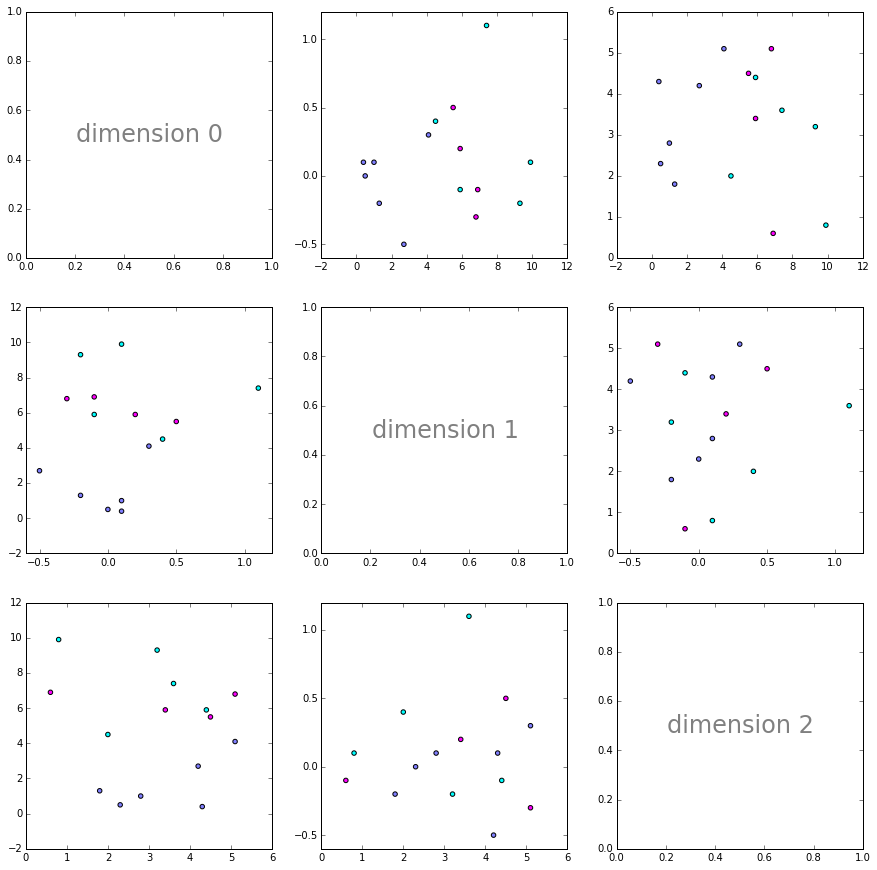

In [10]:
# plot the data

fig, axes = plt.subplots(3,3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        if i != j:
            axes[i,j].scatter(X[:,i], X[:,j], c=Z, cmap=cm.cool)
        else:
            axes[i,j].text(0.5, 0.5, 'dimension %d' % i,
                           ha='center', va='center', size=24, alpha=.5)


In [4]:
# build a decision tree using the data

import itertools

def gini_index(labels, label_values):
    if labels.size == 0:
        return 0
    else:
        n_label = np.sum(labels[:, np.newaxis] == label_values, axis=0)
        return 1 - np.sum(n_label**2)/np.sum(n_label)**2


class DecisionTreeNode:
    def __init__(self, X, Z, depth=np.infty):
        #print('creating node with a dataset of size %d (%d levels remaining)' % (X.shape[0], depth))
        self.X = X
        self.Z = Z
        self.left = None
        self.right = None
        self.split_pos = None
        self.n = Z.shape[0]
        self.depth = depth
        self.split()
        
    def gini(self):
        if self.right is None:
            return gini_index(self.Z, list(set(self.Z)))
        else:
            return (self.right.gini()*self.right.n + self.left.gini()*self.left.n) / self.n
    
    def get_cut_positions(self):
        s = np.sort( self.X, axis=0 )
        return (s[1:] + s[:-1]) / 2
    
    def get_labels(self):
        return list(set(self.Z))
    
    def is_pure(self):
        return len(self.get_labels()) == 1
    
    def get_label_counts(self):
        ls = self.get_labels()
        n_label = np.sum(self.Z[:, np.newaxis] == ls, axis=0)
        return { l:n for (l,n) in zip(ls,n_label) }
    
    def split(self):
        if self.is_pure():
            print('node is pure! refusing to split…')
            return
        if self.depth <= 0:
            print('reached maximum depth! refusing to split…')
            return
        
        label_values = self.get_labels()
        cuts = self.get_cut_positions()
        zz = cuts[:,:,np.newaxis] < self.X.T
        indices = np.array([
                [ (  gini_index(self.Z[ zz[i,j,:]], label_values)*np.sum( zz[i,j,:])
                   + gini_index(self.Z[~zz[i,j,:]], label_values)*np.sum(~zz[i,j,:])
                  )
                  for j in range(zz.shape[1])
                ]
                for i in range(zz.shape[0])
            ])
        min_index = np.argmin(indices)
        split_dim = min_index % indices.shape[1]
        split_dest = min_index // indices.shape[1]
        self.split_pos = (split_dim , cuts[split_dest, split_dim])
        mask = zz[split_dest,split_dim,:]
        # put all elements greater than the splitting boundary into the left node
        self.left = DecisionTreeNode(self.X[mask], self.Z[mask], self.depth-1)
        # all others in the right node
        self.right = DecisionTreeNode(self.X[~mask], self.Z[~mask], self.depth-1)
        return
    
    def subtree_to_str(self, d=0):
        res = self.node_to_str(d)
        if self.left is not None:
            res += '\n'.join(['|' + l for l in itertools.chain(
                        self.left.subtree_to_str(d+1).split('\n'),
                        self.right.subtree_to_str(d+1).split('\n'))
            ])
        
        return res
    
    def node_to_str(self, d=0):
        res = ''
        if self.split_pos is not None:
            res = ('depth: %d -- X%s > %.2f' % (d, chr(ord('₀') + self.split_pos[0] + 1),
                                                self.split_pos[1]))
        else:
            res = ('depth: %d -- leaf' % d)
        res += ' (gini: %.2f)\n' % self.gini()
        nl = self.get_label_counts()
        for l in sorted(nl.keys()):
            res += ('\t%s: %f%%\n' % (str(l), 100*nl[l]/self.n))
        return res


class DecisionTree:
    def __init__(self, X, Z, max_depth=np.infty):
        self.X = X
        self.Z = Z
        self.max_depth = max_depth
        self.root = DecisionTreeNode(X,Z,max_depth)
    
    def gini_index(self):
        return self.root.gini_index()

    def print_tree(self):
        print('DFS traversal of the tree:')
        print(self.root.subtree_to_str(0))


In [5]:
T = DecisionTree(X,Z.astype(int),2)
print(30 * '=' + '\n')
T.print_tree()

node is pure! refusing to split…
reached maximum depth! refusing to split…
node is pure! refusing to split…

DFS traversal of the tree:
depth: 0 -- X₁ > 4.30 (gini: 0.18)
	0: 33.333333%
	1: 40.000000%
	2: 26.666667%
|depth: 1 -- X₁ > 7.15 (gini: 0.30)
|	0: 55.555556%
|	2: 44.444444%
||depth: 2 -- leaf (gini: 0.00)
||	0: 100.000000%
||
||depth: 2 -- leaf (gini: 0.44)
||	0: 33.333333%
||	2: 66.666667%
||
|depth: 1 -- leaf (gini: 0.00)
|	1: 100.000000%
|
